#  Attribution-Based Confidence (ABC) Metric - Step by Step Flowchart Breakdown

##  Step 1: Input Image
- Start with an **input image** from a dataset (e.g., **CIFAR-10**).
---

##  Step 2: Model Prediction
- The image is passed through a **pre-trained deep learning model** (e.g., **ResNet-18**).


##  Step 3: Compute Integrated Gradients (IG)
- Compute **Integrated Gradients (IG)** to determine the **importance of each pixel**.
- IG helps **identify which parts of the image contribute most** to the prediction.

---

##  Step 4: Compute Probability-Based Perturbation

In the paper  each pixel/feature \(x_j\) is perturbed (set to baseline) according to a **Bernoulli** draw whose probability is determined by the Integrated Gradients (IG) attribution *divided by* the feature value. Concretely, let \(A_j(x)\) be the IG attribution for pixel \(x_j\). Then the probability of flipping \(x_j\) to the baseline is given by:

$$
P\bigl(x_j\bigr)
\;=\;
\frac{\bigl|\!A_j(x)\,/\,x_j\bigr|}{
      \sum_{k=1}^{n} \bigl|\!A_k(x)\,/\,x_k\bigr|}
\,.
$$

In other words:

1. **Compute the ratio**  for each pixel \(j\).
2. **Normalize** those ratios across all \(n\) pixels so that they sum to 1.
3. **Sample** from a Bernoulli distribution for each pixel \(j\) using probability \(P(x_j)\). If the Bernoulli draw is 1 (true), set \(x_j\) to its baseline (e.g. 0). Otherwise, leave \(x_j\) unmodified.

This ensures that **pixels with large IG‐based sensitivity** have **higher probability** of being perturbed, and pixels with small sensitivity are less likely to be changed.

---

##  Step 5: Probabilistic Perturbation with Bernoulli Sampling

- **Apply Bernoulli Sampling**: Each pixel's probability of being perturbed is determined by its **Integrated Gradients (IG) attribution**.
- **Random Sampling**: A random value is drawn for each pixel, and if it is **smaller than the probability**, the pixel is **set to the baseline (zero perturbation)**:


##  Step 6: ABC Score Calculation
- The **ABC score** is computed by checking if the **perturbed image retains the original prediction**.
- Mathematically, the **ABC score** is defined as:

  $$
  \text{ABC} = \frac{\sum_{i=1}^{N} \mathbb{1} [\hat{y}_i = y_i]}{N}
  $$

  where:
  - \( N \) is the total number of perturbed samples.
  - \( \hat{y}_i \) is the predicted label after perturbation for sample \( i \).
  - \( y_i \) is the original model prediction for sample \( i \).



Files already downloaded and verified


C:\Users\VISHNU\AppData\Local\Temp\ipykernel_15148\2999794073.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("resnet18_cifar10_bn30epcohs.pth")

 Model loaded successfully!
**Overall ABC Score:** 0.9897
**ABC (Correctly Classified):** 0.9917
**ABC (Misclassified):** 0.9895


C:\Users\VISHNU\AppData\Local\Temp\ipykernel_15148\2999794073.py:183: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


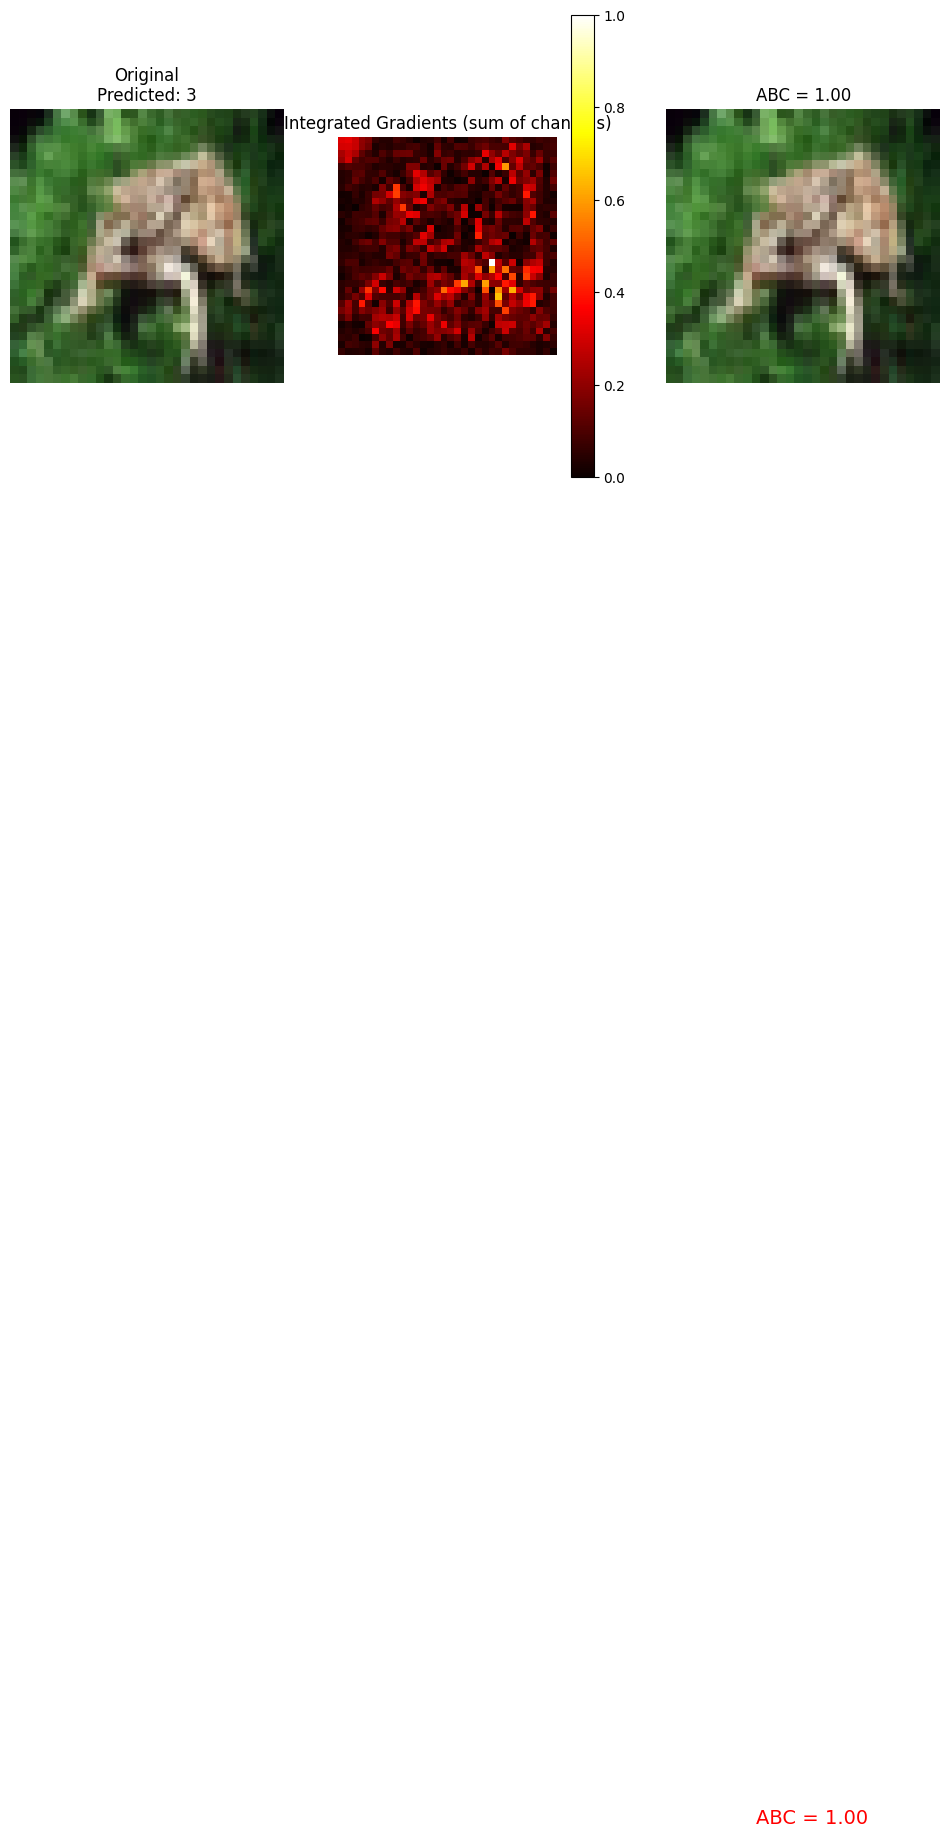

In [2]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

# ---------------------------- 1. Load CIFAR-10 & Pretrained Model ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

state_dict = torch.load("resnet18_cifar10_bn30epcohs.pth")
new_state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}

model = models.resnet18(num_classes=10)  
model.load_state_dict(new_state_dict, strict=False)
model.eval()
print(" Model loaded successfully!")

# ---------------------------- 2. Integrated Gradients (IG) ----------------------------
def integrated_gradients(input_tensor, model, baseline=None, steps=20):
    """
    Compute Integrated Gradients for a CIFAR-10 image.
    """
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()

    if baseline is None:
        baseline = torch.zeros_like(input_tensor)

    total_grad = torch.zeros_like(input_tensor)

    for alpha in torch.linspace(0.0, 1.0, steps):
        x_step = baseline + alpha * (input_tensor - baseline)
        x_step.requires_grad_(True)

        out_step = model(x_step)
        logit_of_interest = out_step[0, predicted_class]

        model.zero_grad()
        logit_of_interest.backward(retain_graph=False)
        grad_x_step = x_step.grad.clone()

        total_grad += grad_x_step

    avg_grad = total_grad / steps
    ig = (input_tensor - baseline) * avg_grad
    return ig

# ---------------------------- 3. Probabilistic Perturbation (Paper Version) ----------------------------
def probabilistic_perturbation(image, ig):
    """
    Applies a Bernoulli perturbation where probability P(x_j) is proportional
    to |IG_j / x_j|.
    We then set perturbed pixels to 0 (zero baseline).
    """
    x_flat = image.view(-1)
    ig_flat = ig.view(-1)

    epsilon = 1e-9
    ratio = (ig_flat / (x_flat + epsilon)).abs()  
    ratio_sum = ratio.sum() + epsilon
    prob = ratio / ratio_sum

    # Draw Bernoulli( prob )
    rnd = torch.rand_like(prob)
    mask = (rnd > prob).float() 

    perturbed_flat = x_flat * mask
    perturbed_image = perturbed_flat.view_as(image)

    return perturbed_image

# ---------------------------- 4. ABC Metric ----------------------------
def abc_metric(input_tensor, model, ig, num_samples=20):
    """
    Compute ABC Metric on CIFAR-10 image using the 'probabilistic_perturbation' approach.
    """
    with torch.no_grad():
        preds = model(input_tensor)
        original_label = preds.argmax(dim=1).item()

    scores = []
    
    for _ in range(num_samples):
        perturbed_image = probabilistic_perturbation(input_tensor, ig)
        
        with torch.no_grad():
            perturbed_pred = model(perturbed_image).argmax(dim=1).item()
        
        scores.append(1 if perturbed_pred == original_label else 0)

    abc_val = sum(scores) / float(num_samples)
    return abc_val

# ---------------------------- 5. Compute ABC Scores Over a Smaller Dataset ----------------------------
def compute_average_abc():
    total_abc = 0
    num_samples = 0
    scores_correct = []
    scores_incorrect = []
    
    selected_sample = None

    for i, (image, label) in enumerate(testloader):
        if i >= 500:
            break
        ig = integrated_gradients(image, model, baseline=None, steps=20)

        abc_val = abc_metric(image, model, ig, num_samples=20)

        with torch.no_grad():
            pred_label = model(image).argmax(dim=1).item()

        total_abc += abc_val
        num_samples += 1
        
        if pred_label == label.item():
            scores_correct.append(abc_val)
        else:
            scores_incorrect.append(abc_val)

        if random.random() < 1/(i + 1):
            selected_sample = (image, label, pred_label, ig, abc_val)

    avg_abc = total_abc / num_samples
    avg_correct = sum(scores_correct) / len(scores_correct) if scores_correct else None
    avg_incorrect = sum(scores_incorrect) / len(scores_incorrect) if scores_incorrect else None

    print(f"**Overall ABC Score:** {avg_abc:.4f}")
    if avg_correct is not None:
        print(f"**ABC (Correctly Classified):** {avg_correct:.4f}")
    if avg_incorrect is not None:
        print(f"**ABC (Misclassified):** {avg_incorrect:.4f}")

    return selected_sample, avg_abc, avg_correct, avg_incorrect

# ---------------------------- 6. Visualization ----------------------------
def visualize_sample(selected_sample):
    image, label, pred_label, ig, abc_val = selected_sample

    def unnormalize(img):
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
        std = torch.tensor([0.247, 0.243, 0.261]).view(3,1,1)
        return img * std + mean

    image_disp = unnormalize(image[0].detach()).permute(1,2,0).numpy()
    
    ig_map = ig.abs().sum(dim=1, keepdim=True)[0, 0].cpu().numpy()  # Sum IG across channels
    ig_map = (ig_map - ig_map.min()) / (ig_map.max() - ig_map.min() + 1e-9)  # Normalize
    
    # Plot
    plt.figure(figsize=(12,6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image_disp)
    plt.title(f"Original\nPredicted: {pred_label}")
    plt.axis('off')

    # IG Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(ig_map, cmap='hot')
    plt.colorbar()
    plt.title("Integrated Gradients (sum of channels)")
    plt.axis('off')

    # ABC Score
    plt.subplot(1, 3, 3)
    plt.imshow(image_disp)
    plt.text(10, 200, f"ABC = {abc_val:.2f}", color='red', fontsize=14)
    plt.title(f"ABC = {abc_val:.2f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ---------------------------- 7. Run Experiment ----------------------------
def main():
    selected_sample, avg_abc, avg_correct, avg_incorrect = compute_average_abc()
    if selected_sample:
        visualize_sample(selected_sample)

if __name__ == '__main__':
    main()


 Model Loaded Successfully!

 **ABC Score (Clean Image):** 1.0000


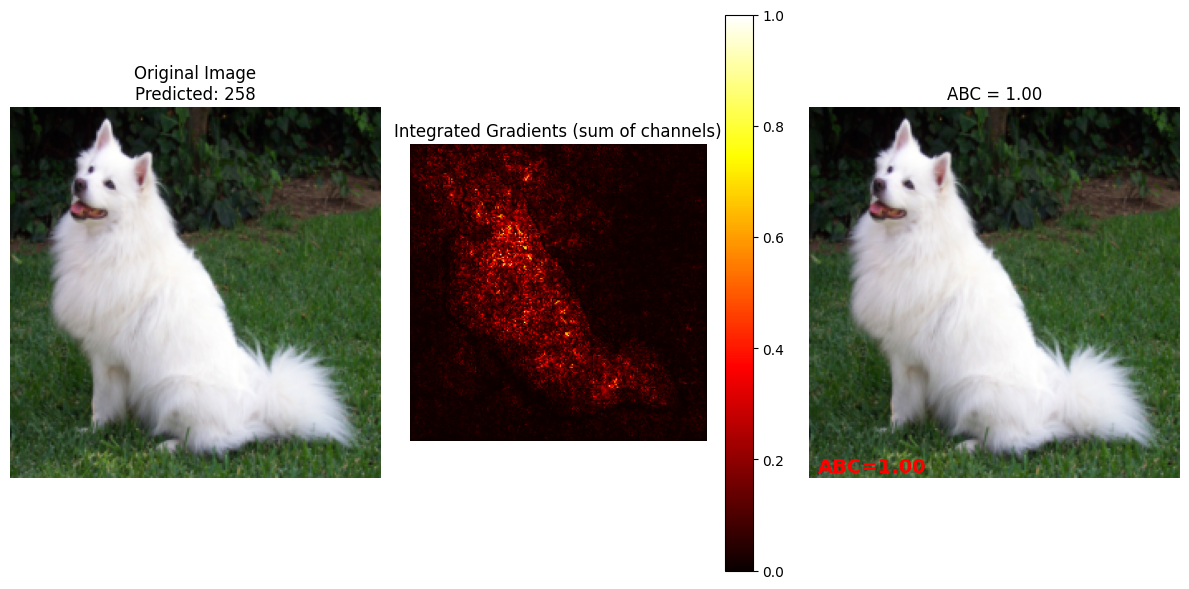

In [39]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from io import BytesIO

# ---------------------------- 1. Load High-Quality Image from GitHub ----------------------------

image_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"  # Replace with your own
def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    return image

image = load_image_from_url(image_url)
image.show()

# Define Transformations for Model Input
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# Convert image to tensor
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# ---------------------------- 2. Load Pretrained Model ----------------------------

model = models.resnet18(pretrained=True)
model.eval()
print(" Model Loaded Successfully!")

# ---------------------------- 3. Integrated Gradients (IG) ----------------------------

def integrated_gradients(input_tensor, model, baseline=None, steps=50):
    """
    Compute Integrated Gradients for the given image.
    """
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()

    if baseline is None:
        baseline = torch.zeros_like(input_tensor)

    total_grad = torch.zeros_like(input_tensor)

    for alpha in torch.linspace(0.0, 1.0, steps):
        x_step = baseline + alpha * (input_tensor - baseline)
        x_step.requires_grad_(True)

        out_step = model(x_step)
        logit_of_interest = out_step[0, predicted_class]

        model.zero_grad()
        logit_of_interest.backward()
        grad_x_step = x_step.grad.clone()

        total_grad += grad_x_step

    avg_grad = total_grad / steps
    ig = (input_tensor - baseline) * avg_grad
    return ig, predicted_class

# ---------------------------- 4. Probabilistic Perturbation Based on IG ----------------------------

def probabilistic_perturbation(image, ig, min_prob=0.1):
    """
    Apply a probabilistic perturbation to an image based on IG importance.
    Pixels with high IG values are more likely to be perturbed.
    """
    x_flat = image.view(-1)
    ig_flat = ig.abs().view(-1)
    
    prob = ig_flat / (ig_flat.sum() + 1e-9)
    prob = torch.clamp(prob, min=min_prob)

    mask = (torch.rand_like(prob) > prob).float()
    perturbed_flat = x_flat * mask
    perturbed_image = perturbed_flat.view(image.shape)
    
    return perturbed_image

# ---------------------------- 5. ABC Metric ----------------------------

def abc_metric(input_tensor, model, ig, num_samples=20):
    """
    Compute ABC Metric using probabilistic perturbation.
    """
    with torch.no_grad():
        preds = model(input_tensor)
        original_label = preds.argmax(dim=1).item()

    scores = []
    for _ in range(num_samples):
        perturbed_image = probabilistic_perturbation(input_tensor, ig)
        with torch.no_grad():
            perturbed_pred = model(perturbed_image).argmax(dim=1).item()
        scores.append(perturbed_pred == original_label)
    
    return sum(scores) / num_samples

# ---------------------------- 6. Compute ABC Scores ----------------------------

def compute_abc():
    ig, pred_label = integrated_gradients(image_tensor, model, steps=50)
    abc_val = abc_metric(image_tensor, model, ig, num_samples=20)

    print(f"\n **ABC Score (Clean Image):** {abc_val:.4f}")

    return image_tensor, pred_label, ig, abc_val

# ---------------------------- 7. Visualization ----------------------------

def visualize_sample(image_tensor, pred_label, ig, abc_val):
    """
    Visualize the original image, IG heatmap, and ABC score.
    """

    # Convert images for display
    unnormalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
    ])
    image_disp = unnormalize(image_tensor[0]).permute(1,2,0).cpu().numpy()

    ig_map = ig.abs().sum(dim=1, keepdim=True)[0, 0].cpu().numpy()  # Sum IG across channels
    ig_map = (ig_map - ig_map.min()) / (ig_map.max() - ig_map.min() + 1e-9)  # Normalize

    # Plot Results
    plt.figure(figsize=(12,6), dpi=100)

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image_disp)
    plt.title(f"Original Image\nPredicted: {pred_label}")
    plt.axis('off')

    # IG Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(ig_map, cmap='hot')
    plt.colorbar()
    plt.title("Integrated Gradients (sum of channels)")
    plt.axis('off')

    # ABC Score Display
    plt.subplot(1, 3, 3)
    plt.imshow(image_disp)
    plt.text(5, 220, f"ABC={abc_val:.2f}", color='red', fontsize=14, fontweight='bold')
    plt.title(f"ABC = {abc_val:.2f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ---------------------------- 8. Run Experiment ----------------------------

def main():
    image_tensor, pred_label, ig, abc_val = compute_abc()
    visualize_sample(image_tensor, pred_label, ig, abc_val)

if __name__ == '__main__':
    main()


# Now I am randomly computing ABC on a overfitted model just to know if this overfitted model will lose its stability under these attribution‐based perturbations

Files already downloaded and verified


C:\Users\VISHNU\AppData\Local\Temp\ipykernel_15148\1441275976.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("overfitting_resnet_no_bn.pth")


 Model loaded successfully!
**Overall ABC Score:** 0.9989
**ABC (Correctly Classified):** 1.0000
**ABC (Misclassified):** 0.9988


C:\Users\VISHNU\AppData\Local\Temp\ipykernel_15148\1441275976.py:183: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


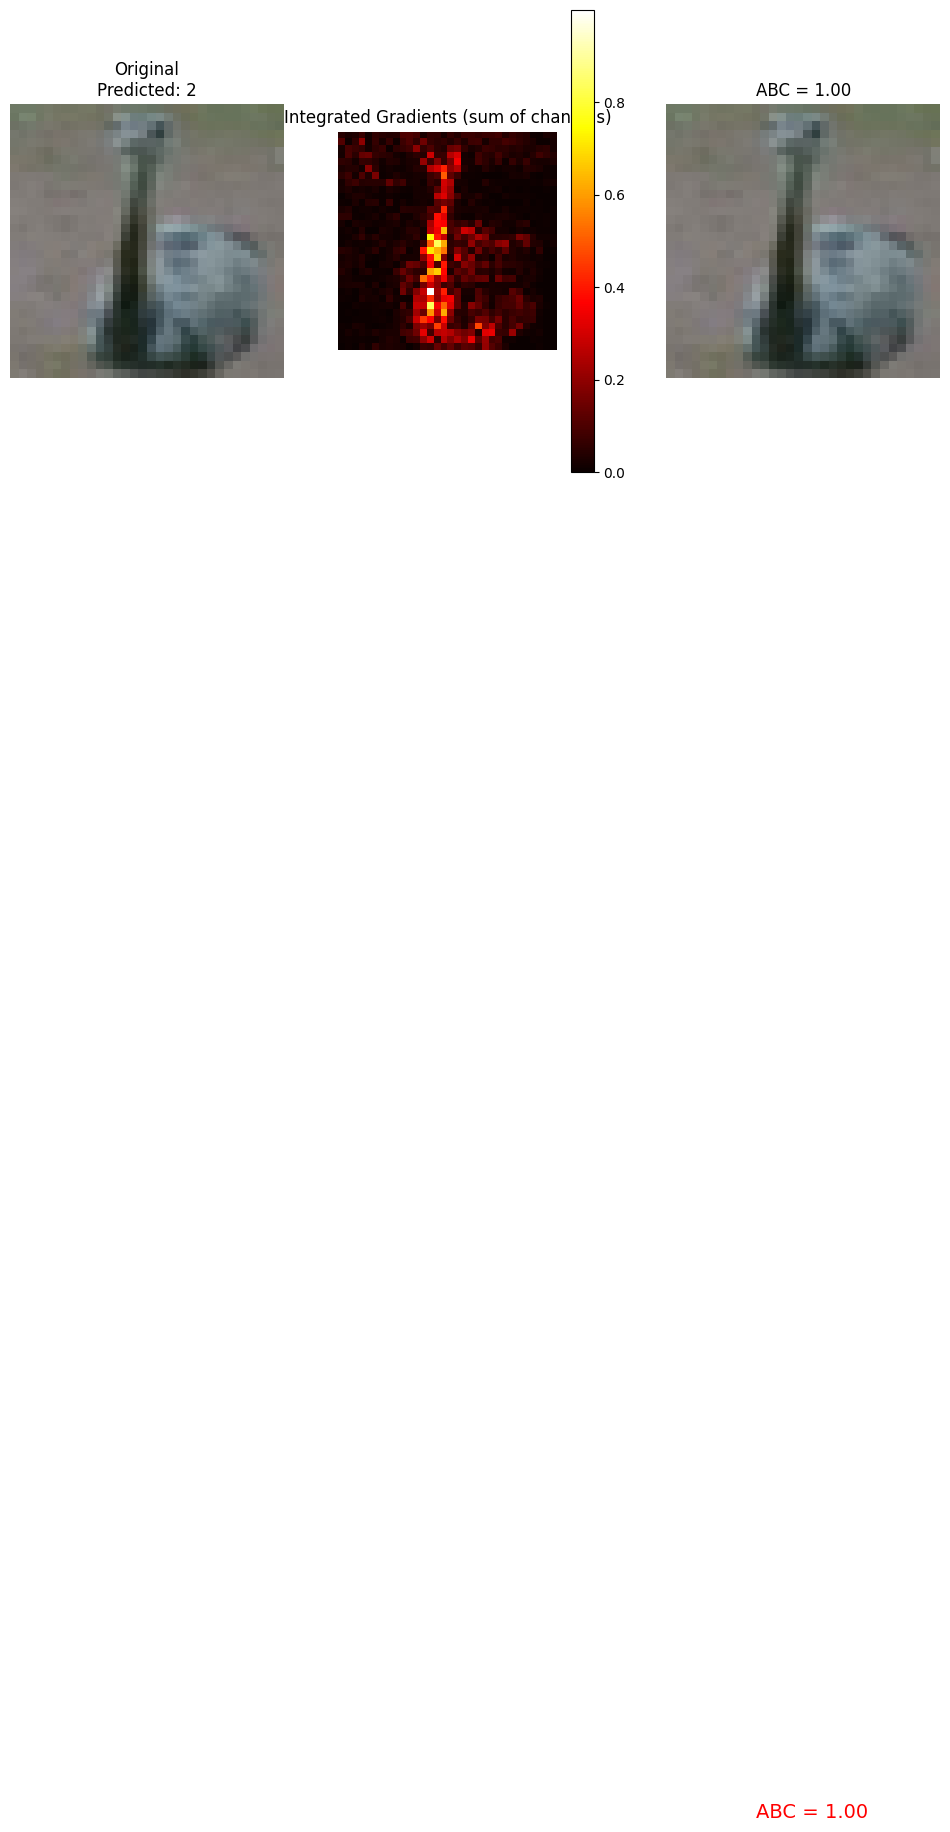

In [6]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

# ---------------------------- 1. Load CIFAR-10 & Pretrained Model ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

state_dict = torch.load("overfitting_resnet_no_bn.pth")
new_state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}

model = models.resnet18(num_classes=10)  
model.load_state_dict(new_state_dict, strict=False)
model.eval()
print(" Model loaded successfully!")

# ---------------------------- 2. Integrated Gradients (IG) ----------------------------
def integrated_gradients(input_tensor, model, baseline=None, steps=20):
    """
    Compute Integrated Gradients for a CIFAR-10 image.
    """
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()

    if baseline is None:
        baseline = torch.zeros_like(input_tensor)

    total_grad = torch.zeros_like(input_tensor)

    for alpha in torch.linspace(0.0, 1.0, steps):
        x_step = baseline + alpha * (input_tensor - baseline)
        x_step.requires_grad_(True)

        out_step = model(x_step)
        logit_of_interest = out_step[0, predicted_class]

        model.zero_grad()
        logit_of_interest.backward(retain_graph=False)
        grad_x_step = x_step.grad.clone()

        total_grad += grad_x_step

    avg_grad = total_grad / steps
    ig = (input_tensor - baseline) * avg_grad
    return ig

# ---------------------------- 3. Probabilistic Perturbation (Paper Version) ----------------------------
def probabilistic_perturbation(image, ig):
    """
    Applies a Bernoulli perturbation where probability P(x_j) is proportional
    to |IG_j / x_j|.
    We then set perturbed pixels to 0 (zero baseline).
    """
    x_flat = image.view(-1)
    ig_flat = ig.view(-1)

    epsilon = 1e-9
    ratio = (ig_flat / (x_flat + epsilon)).abs()  
    ratio_sum = ratio.sum() + epsilon
    prob = ratio / ratio_sum

    # Draw Bernoulli( prob )
    rnd = torch.rand_like(prob)
    mask = (rnd > prob).float() 

    perturbed_flat = x_flat * mask
    perturbed_image = perturbed_flat.view_as(image)

    return perturbed_image

# ---------------------------- 4. ABC Metric ----------------------------
def abc_metric(input_tensor, model, ig, num_samples=20):
    """
    Compute ABC Metric on CIFAR-10 image using the 'probabilistic_perturbation' approach.
    """
    with torch.no_grad():
        preds = model(input_tensor)
        original_label = preds.argmax(dim=1).item()

    scores = []
    
    for _ in range(num_samples):
        perturbed_image = probabilistic_perturbation(input_tensor, ig)
        
        with torch.no_grad():
            perturbed_pred = model(perturbed_image).argmax(dim=1).item()
        
        scores.append(1 if perturbed_pred == original_label else 0)

    abc_val = sum(scores) / float(num_samples)
    return abc_val

# ---------------------------- 5. Compute ABC Scores Over a Smaller Dataset ----------------------------
def compute_average_abc():
    total_abc = 0
    num_samples = 0
    scores_correct = []
    scores_incorrect = []
    
    selected_sample = None

    for i, (image, label) in enumerate(testloader):
        if i >= 500:
            break
        ig = integrated_gradients(image, model, baseline=None, steps=20)

        abc_val = abc_metric(image, model, ig, num_samples=20)

        with torch.no_grad():
            pred_label = model(image).argmax(dim=1).item()

        total_abc += abc_val
        num_samples += 1
        
        if pred_label == label.item():
            scores_correct.append(abc_val)
        else:
            scores_incorrect.append(abc_val)

        if random.random() < 1/(i + 1):
            selected_sample = (image, label, pred_label, ig, abc_val)

    avg_abc = total_abc / num_samples
    avg_correct = sum(scores_correct) / len(scores_correct) if scores_correct else None
    avg_incorrect = sum(scores_incorrect) / len(scores_incorrect) if scores_incorrect else None

    print(f"**Overall ABC Score:** {avg_abc:.4f}")
    if avg_correct is not None:
        print(f"**ABC (Correctly Classified):** {avg_correct:.4f}")
    if avg_incorrect is not None:
        print(f"**ABC (Misclassified):** {avg_incorrect:.4f}")

    return selected_sample, avg_abc, avg_correct, avg_incorrect

# ---------------------------- 6. Visualization ----------------------------
def visualize_sample(selected_sample):
    image, label, pred_label, ig, abc_val = selected_sample

    def unnormalize(img):
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
        std = torch.tensor([0.247, 0.243, 0.261]).view(3,1,1)
        return img * std + mean

    image_disp = unnormalize(image[0].detach()).permute(1,2,0).numpy()
    
    ig_map = ig.abs().sum(dim=1, keepdim=True)[0, 0].cpu().numpy()  # Sum IG across channels
    ig_map = (ig_map - ig_map.min()) / (ig_map.max() - ig_map.min() + 1e-9)  # Normalize
    
    # Plot
    plt.figure(figsize=(12,6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image_disp)
    plt.title(f"Original\nPredicted: {pred_label}")
    plt.axis('off')

    # IG Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(ig_map, cmap='hot')
    plt.colorbar()
    plt.title("Integrated Gradients (sum of channels)")
    plt.axis('off')

    # ABC Score
    plt.subplot(1, 3, 3)
    plt.imshow(image_disp)
    plt.text(10, 200, f"ABC = {abc_val:.2f}", color='red', fontsize=14)
    plt.title(f"ABC = {abc_val:.2f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ---------------------------- 7. Run Experiment ----------------------------
def main():
    selected_sample, avg_abc, avg_correct, avg_incorrect = compute_average_abc()
    if selected_sample:
        visualize_sample(selected_sample)

if __name__ == '__main__':
    main()


# So what ABC is saying this overfitted model doesn’t change its prediction when I perturb the important parts.

This means the overfitted model is **more stable**, which is not always a good sign.  
In simple terms, you can say:

**High ABC ≠ Good model**  
**High ABC = Model is sure about its decision, even if it's wrong**